In [2]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
from scipy.special import softmax

In [3]:
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
# context_generator = synthetic_data.QuinticContexts_imbalanced(  )
context_generator.set_b(0)
context_generator.normalization()
context_generator.set_b(0.3)

##### deployment data:

X_depl, y_depl, dist_depl = None, None, []
# X_depl2, y_depl2, dist_depl2 = None, None, []

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_depl.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl = norm_context if X_depl is None else np.concatenate((X_depl, norm_context), axis=0)
    y_depl = [[outcome]] if y_depl is None else np.concatenate( (y_depl, [[outcome]]), axis=0)

# for _ in range(10000):
#     norm_context, distribution = context_generator.get_context(True)
#     dist_depl2.append(distribution)
#     outcome = np.random.choice( 2 , p = distribution ) 
#     X_depl2 = norm_context if X_depl2 is None else np.concatenate((X_depl2, norm_context), axis=0)
#     y_depl2 = [[outcome]] if y_depl2 is None else np.concatenate( (y_depl2, [[outcome]]), axis=0)

print( X_depl.shape , y_depl.shape )
# print( X_depl2.shape , y_depl2.shape )

(10000, 2) (10000, 1)


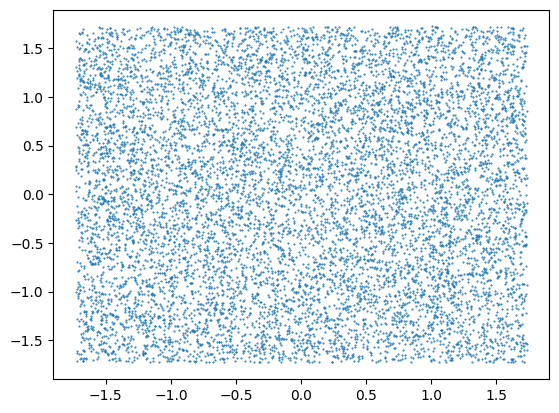

In [3]:
plt.plot(X_depl[:,0], X_depl[:,1], '.', markersize = 1)

In [4]:
class OriginalNetwork(nn.Module):
    def __init__(self,  d, m):
        super(OriginalNetwork, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.ReLU()
        self.fc3 = nn.Linear(m, m)
        self.activate3 = nn.ReLU()
        self.fc4 = nn.Linear(m, 2)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc4.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    def forward(self, x):
        x = self.fc4( self.activate3( self.fc3( self.activate2( self.fc2( self.activate1( self.fc1( x ) ) ) ) ) ) )
        return x

class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self,game,alg, depl_model, X, y, dist):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for context, gt, distribution in zip(X, y, dist):
            
            y_pred = depl_model( torch.from_numpy( context ).float().to(alg.device) ).cpu().detach()#.numpy()
            probabilities = torch.softmax(y_pred, dim=0).numpy()
            prediction = np.argmax(probabilities)

            print('ground truth', gt, 'prediction', prediction)
            outcome = 1 if gt[0] == prediction else 0

            context = context.reshape( (1, -1) )
            # outcome = outcome[0]

            action, data = alg.get_action(t, context, prediction)

            data.append( context )
            history.append( data )

            print('t', t, 'action', action, 'outcome', outcome, 'counter', alg.counter,  )
            feedback =  self.get_feedback( game, action, outcome )
            if alg.over_budget == False:
                print('hey')
                loss, losses = alg.update(action, feedback, outcome, t, context )

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

        return history, cumRegret, global_loss, global_losses

In [5]:
import numpy as np
import random
import torch
import cbpside
import rand_cbpside
import synthetic_data
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint2
import games
import explore_commit2

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

budget = 2000

# game = games.label_efficient( )
game = games.tho_detection( 0.3 )
# game = games.apple_tasting()

depl_model = OriginalNetwork(2, 20).to('cuda:0')
depl_model.load_state_dict(torch.load('./models/quintic_bce.pth'))
depl_model.to('cuda:0')

lbd_neural = 0
lbd_reg = 1
sigma = 1/8
K = 10
epsilon = 10e-7
alg = rand_neural_lin_cbpside_disjoint2.CBPside( game,  budget, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, 20, 'cuda:0')

# alg = explore_commit2.ExploreCommit(game, budget, 2, 0, 20, 'cuda:0')

alg.reset(context_generator.d)
# path = './models/quintic.pth'
# alg.load(path)

evaluator = Evaluate()

Restricted license - for non-production use only - expires 2024-10-28


In [6]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, alg, depl_model, X_depl, y_depl, dist_depl)

ground truth [0] prediction 0
t 0 action 0 outcome 1 counter 0
hey
ground truth [0] prediction 0
t 1 action 1 outcome 1 counter 1
hey
ground truth [0] prediction 1
factor 3.0357518943114608 width [[0.04135258]]
factor 2.3690852276447947 width [[0.04133235]]
estimate [array([[-0.00149779,  0.        ]]), array([[-0.00197348]])]
conf    [array([[0.12553618]]), array([[0.09791987]])]
pair [0, 1] tdelta [-0.00149779] confidence [[0.25107236]]
0 0.001710036103015171 0.4469350288907768
1 0.0017083633928053454 inf
union1 [0 1] R []
t 2 action 0 outcome 0 counter 1
hey
ground truth [0] prediction 0
factor 0.0 width [[0.0583439]]
factor 0.7838885884593848 width [[0.05847106]]
estimate [array([[0.00754248, 0.00041794]]), array([[0.00652945]])]
conf    [array([[0.]]), array([[0.0458348]])]
pair [0, 1] tdelta [0.0067066] confidence [[0.]]
union1 [1] R []
t 3 action 1 outcome 1 counter 2
hey
ground truth [0] prediction 0
factor 1.003110254553481 width [[0.12205333]]
factor 0.0 width [[0.12210691]]


In [7]:
train_hist = [sublist for sublist in history if sublist[4] is False]
depl_hist = [sublist for sublist in history if sublist[4] is True]

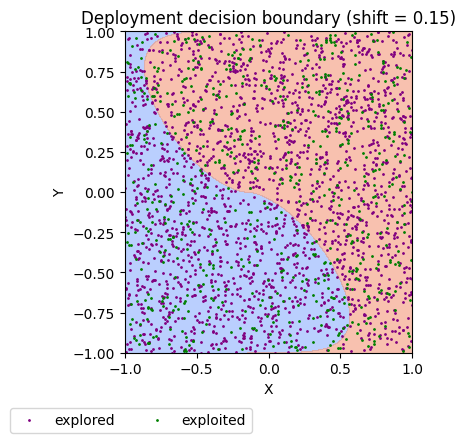

In [8]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i[5]) for i in train_hist ] ).squeeze(1) 

action1 = [ i[0] if i[0]==0 else np.nan for i in train_hist ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==1 else np.nan for i in train_hist ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', markersize = 2, label = 'predicted as class 1')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', markersize = 2, label = 'predicted as class 2')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'purple', markersize = 2, label = 'explored')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', markersize = 2, label = 'exploited')

plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/ETC_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')

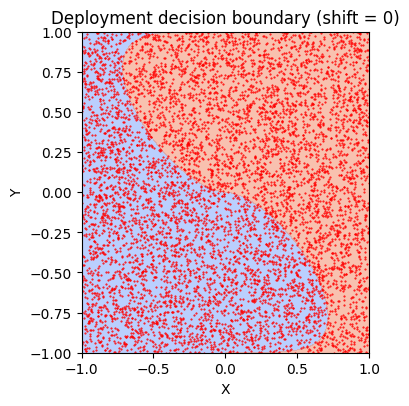

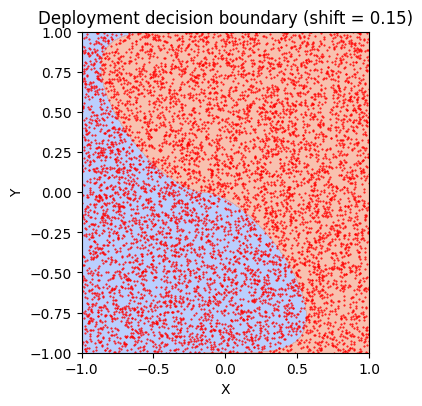

In [9]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0, 0.15]: #[0, 0.15]

    plt.figure( figsize=(4, 4) )

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i[5]) for i in depl_hist ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==1 else np.nan for i in depl_hist ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    # action1 = [ i[0] if i[0]==0 and i[1]==0 else np.nan for i in depl_hist ]
    # indices_action1 = np.where(~np.isnan(action1))[0]
    # contexts1 = contexts[indices_action1]
    # action2 = [ i[0] if i[0]==0 and i[1]==1 else np.nan for i in depl_hist ]
    # indices_action2 = np.where(~np.isnan(action2))[0]
    # contexts2 = contexts[indices_action2]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', markersize = 1, color = 'red')
    # plt.plot(contexts1[:,0], contexts1[:,1], '.', markersize = 1, color = 'red')
    # plt.plot(contexts2[:,0], contexts2[:,1], '.', markersize = 1, color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('Deployment decision boundary (shift = {})'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/ETC_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')
    # plt.savefig('./figures/CBP_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')

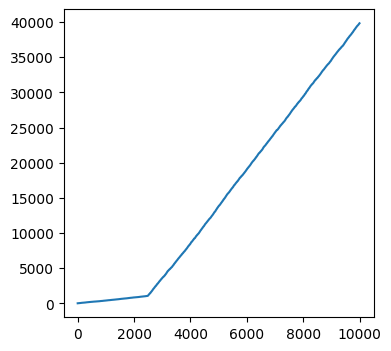

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(cumRegret))
# plt.ylim((0,3000))
# plt.savefig('./figures/ETC_regret3.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret3.png', dpi=380, bbox_inches='tight')

Text(0, 0.5, 'Loss')

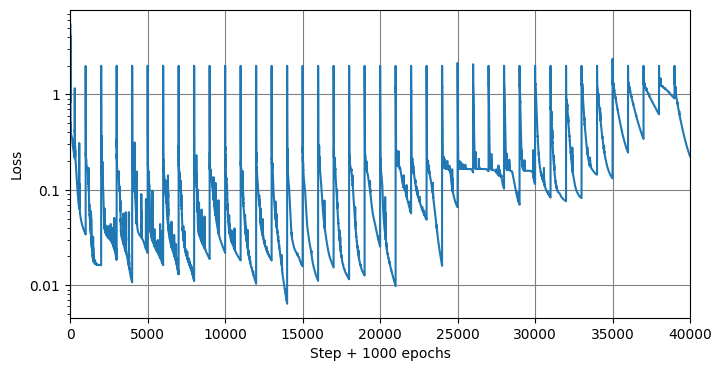

In [24]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1500

custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


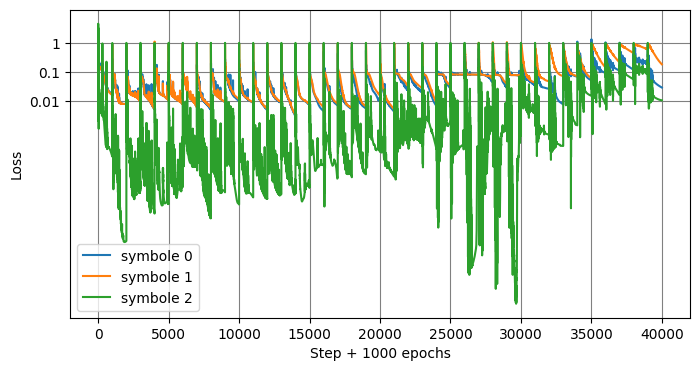

In [27]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
# plt.xlim( (-10, 19000) )

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1',  ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
# plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


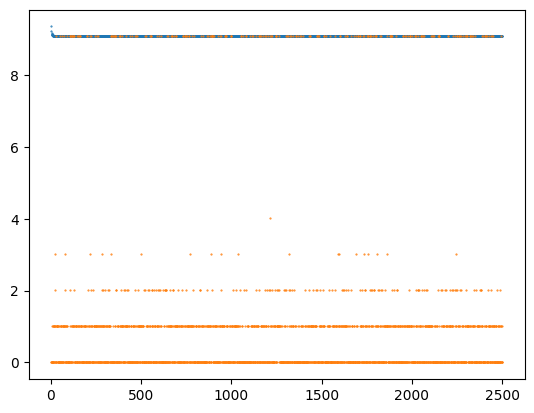

In [66]:


def obtain_probability(t , factor):

    sigma = 1
    K = 10
    epsilon = 0.1#10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 2
    N = 3
    H = 50
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)


(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

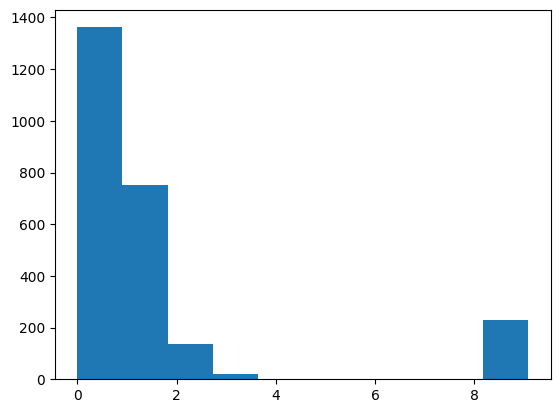

In [67]:
plt.hist(rand, bins = 10)

In [1]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined